## A simple model for demand and supply of publicly-provided services in a city

In [9]:
from enum import Enum
import os.path

import numpy as np
import pandas as pd
import geopandas as gpd
import geopy, geopy.distance
import shapely
from sklearn import gaussian_process

from matplotlib import pyplot as plt 
import seaborn as sns
plt.rcParams['figure.figsize']= (20,14)

In [2]:
from cityItems import AgeGroup, ServiceArea, ServiceType, SummaryNorm # enum classes for the model

In [44]:
gaussKern = gaussian_process.kernels.RBF
get_random_pos = lambda n: list(map(geopy.Point, list(zip(np.round(np.random.uniform(45.40, 45.50, n), 5), 
                                np.round(np.random.uniform(9.1, 9.3, n), 5)))))
make_shapely_point = lambda geoPoint: shapely.geometry.Point(tuple(geoPoint))

In [4]:
## ServiceUnit class
class ServiceUnit:
    def __init__(self, service, name='', position=geopy.Point(45.4641, 9.1919),
                 ageDiffusionIn={}, scaleIn=1, attributesIn={}):
        assert isinstance(position, geopy.Point), 'Position must be a geopy Point' 
        assert isinstance(service, ServiceType), 'Service must belong to the Eum'
        assert isinstance(name, str), 'Name must be a string'
        
        assert (np.isscalar(scaleIn)) & (scaleIn>0) , 'Scale must be a positive scalar'
        assert isinstance(attributesIn, dict), 'Attributes can be provided in a dict'
        
        self.name = name
        self.service = service
        
        # A ServiceType can have many sites, so each unit has its own. 
        # Moreover, a site is not uniquely assigned to a service
        self.site = position
        
        self.scale = scaleIn # store scale info
        self.attributes = attributesIn# dictionary
        
        # how the service availablity area varies for different age groups
        if ageDiffusionIn==None:
            self.ageDiffusion = {g: (1 + .005*np.round(np.random.normal(),2))*self.scale for g in AgeGroup.all()} 
        else:
            assert set(ageDiffusionIn.keys()) <= set(AgeGroup.all()), 'Diffusion keys should be AgeGroups'
            #assert all
            self.ageDiffusion = ageDiffusionIn
            
        # define kernel taking scale into account
        self.kernel = {g: gaussKern(length_scale=l*self.scale) for g, l in self.ageDiffusion.items()}
        
        
    def evaluate(self, targetPositions, ageGroup):
        assert all([isinstance(t, geopy.Point) for t in targetPositions]),'Geopy Points expected'
        
        # get distances
        distances = np.zeros(shape=(len(targetPositions),1))
        distances[:,0] = [geopy.distance.great_circle(x, self.site).km for x in targetPositions]
        
        # evaluate kernel to get level service score. If age group is not relevant to the service, return 0 as default
        if self.kernel.__contains__(ageGroup):
            score = self.kernel[ageGroup](distances, np.array([[0],]))
            # check conversion from tuple to nparray
            #targetPositions= np.array(targetPositions)
            #score2 = self.kernel[ageGroup](targetPositions, reshapedPos)
            #assert all(score-score2==0)
        else:
            score = np.zeros_like(targetPositions)
        return np.squeeze(score)
    
    @property
    def users(self): return list(self.propagation.keys())

In [5]:
### Supply modelling
def evaluate_services_at(positions, unitsList, outputServices= [t for t in ServiceType]):
    assert all([isinstance(t, geopy.Point) for t in positions]),'Geopy Points expected'
    # set all age groups as output default
    outputAgeGroups = AgeGroup.all()
    # initialise output
    outScores = {service: pd.DataFrame(np.zeros([len(positions), len(AgeGroup.all())]), 
                                 index=[tuple(t) for t in positions], columns=AgeGroup.all()) 
                 for service in outputServices}
    # loop over different services
    for thisServType in outputServices:
        serviceUnits = [u for u in unitsList if u.service == thisServType]
        if not serviceUnits:
            continue
        else:
            for thisAgeGroup in outputAgeGroups:
                unitValues = np.stack(list(map(lambda x: x.evaluate(positions, thisAgeGroup), serviceUnits)), axis=-1)
                # aggregate unit contributions according to the service type norm
                outScores[thisServType][thisAgeGroup] = thisServType.aggregate_units(unitValues)
            
    return outScores
        

In [6]:
test = [ServiceUnit(ServiceType.PoliceStation, 'Duomo', ageDiffusionIn=None), 
        ServiceUnit(ServiceType.PoliceStation, 'Ripamonti', 
                    position=geopy.Point(45.43, 9.201), ageDiffusionIn=None)]
evaluate_services_at(get_random_pos(4), test)


{<ServiceType.PoliceStation: (2, <ServiceArea.PublicSafety: 2>, <function SummaryNorm.<lambda> at 0x7fcb6919c2f0>)>:                           AgeGroup.Newborn  AgeGroup.ChildPrimary  \
 (45.40014, 9.26893, 0.0)      2.382146e-09           3.518537e-09   
 (45.4616, 9.26702, 0.0)       4.327747e-08           3.126873e-08   
 (45.47785, 9.19884, 0.0)      2.734265e-01           2.665857e-01   
 (45.44573, 9.11018, 0.0)      2.560482e-10           1.663307e-10   
 
                           AgeGroup.ChildMid  AgeGroup.ChildHigh  \
 (45.40014, 9.26893, 0.0)       3.009722e-09        2.172129e-09   
 (45.4616, 9.26702, 0.0)        3.195607e-08        2.250126e-08   
 (45.47785, 9.19884, 0.0)       2.670802e-01        2.600047e-01   
 (45.44573, 9.11018, 0.0)       1.716528e-10        1.086557e-10   
 
                           AgeGroup.Young  AgeGroup.Junior  AgeGroup.Senior  \
 (45.40014, 9.26893, 0.0)    3.087487e-09     3.875689e-09     3.167103e-09   
 (45.4616, 9.26702, 0.0)     3.5

In [7]:
class UnitFactory:
    def __init__(self, path):
        assert os.path.isfile(path), 'File "%s" not found' % path
        self.filepath = path
        self.rawData = []
        
    def load(self):
        self.rawData = pd.read_csv(self.filepath, sep=';', decimal=',')
        self.nUnits = self.rawData.shape[0]
        defaultLocationColumns = ['Lat', 'Long']
        if set(defaultLocationColumns).issubset(set(self.rawData.columns)):
            print('Location data found')
            # store geolocations as geopy Point
            locations = [geopy.Point(self.rawData.loc[i, defaultLocationColumns]) for i in range(self.nUnits)]
            propertData = self.rawData.drop(defaultLocationColumns, axis=1)
        else:
            propertData = self.rawData
            locations = []
            
        return propertData, locations

    @staticmethod
    def createLoader(serviceType, path):
        if serviceType == ServiceType.School:
            return SchoolFactory(path)

In [8]:
class SchoolFactory(UnitFactory):
    
    def __init__(self, path):
        super().__init__(path)
        
    def load(self, meanRadius):
        
        assert meanRadius, 'Please provide a reference radius for the mean school size'
        (propertData, locations) = super().load()
        
        nameCol = 'DENOMINAZIONESCUOLA'
        typeCol = 'ORDINESCUOLA'
        scaleCol = 'ALUNNI'
        
        typeAgeDict = {'SCUOLA PRIMARIA': {AgeGroup.ChildPrimary:1},
                      'SCUOLA SECONDARIA I GRADO': {AgeGroup.ChildMid:1},
                      'SCUOLA SECONDARIA II GRADO': {AgeGroup.ChildHigh:1},}
        
        schoolTypes = propertData[typeCol].unique()
        assert set(schoolTypes) <= set(typeAgeDict.keys()), 'Unrecognized types in input'
        
        # set the scale to be proportional to the square root of number of children
        scaleData = propertData[scaleCol]**.5
        scaleData = scaleData/scaleData.mean() * meanRadius #mean value is mapped to input parameter
        propertData[scaleCol] = scaleData 
        unitList = []
                
        for scType in schoolTypes:
            bThisGroup = propertData[typeCol]==scType
            typeData = propertData[bThisGroup]
            typeLocations = [l for i,l in enumerate(locations) if bThisGroup[i]]

            for iUnit in range(typeData.shape[0]):
                rowData = typeData.iloc[iUnit,:]
                attrDict = {'level':scType}
                thisUnit = ServiceUnit(ServiceType.School, 
                        name=rowData[nameCol], 
                        position=typeLocations[iUnit], 
                        ageDiffusionIn=typeAgeDict[scType], 
                        scaleIn=rowData[scaleCol],
                        attributesIn=attrDict)
                unitList.append(thisUnit)
        
        return unitList

In [9]:
## Load scuole!
scuoleFile =  'final/milano_datiScuole.csv'
schoolLoader = UnitFactory.createLoader(ServiceType.School, scuoleFile)
schoolUnits = schoolLoader.load(0.5)

Location data found


In [ ]:
## Aggregation
class UnitAggregator:
    '''
    A class to evaluate services on a grid and get average values for given land subdivisions
    '''
    
    def __init__(self, unitList, cityGeoFilesDict, gridStep=0.1): #gridStep in km
        assert isinstance(unitList, list), 'List expected'
        assert all([isinstance(t, ServiceUnit) for t in unitList]), 'ServiceUnits expected in list'
        self.units = unitList
        self.quartiereKey = 'quartieri' #hardcoded
        self.IDquartiereCol = 'ID_NIL'
        
        # load division geofiles with geopandas
        self.subdivisions = {}
        for name, fileName in cityGeoFilesDict.items():
            self.subdivisions[name] = gpd.read_file(fileName)
            
        # compute city boundary
        self.cityBoundary = shapely.ops.cascaded_union(self.subdivisions[quartiereKey]['geometry'])
        
        # precompute coordinate ranges
        self.latRange = (self.cityBoundary.bounds[0], self.cityBoundary.bounds[2])
        self.longRange = (self.cityBoundary.bounds[1], self.cityBoundary.bounds[3])
        self.IDquartiere = 
        # precompute plotting grid
        (self.xPlot, self.yPlot) = np.meshgrid(np.linspace(*self.longRange, gridSize),
                                               np.linspace(*self.latRange, gridSize),
                                        indexing='ij')
        
        # construct point objects with same shape
        self.plotPoints = np.empty_like(self.xPlot, dtype=object)
        self.bInPerimeter =  np.empty_like(self.xPlot, dtype=bool)
        
        for (i,j),_ in np.ndenumerate(self.plotPoints):
            self.plotPoints[i,j] = geopy.Point(self.yPlot[i,j], self.xPlot[i,j]) # (lat, long) format
            # mark points outside boundaries
            self.bInPerimeter[i,j] = self.cityBoundary.contains(make_shapely_point(self.plotPoints[i,j]))
            if self.bInPerimeter[i,j]:
                
        
        self.serviceValues = {}

    
    @property
    def longitude(self):
        return [unit.site.longitude for unit in self.units]
    @property
    def latitude(self):
        return [unit.site.latitude for unit in self.units]
    @property
    def scale(self):
        scales = [unit.scale for unit in self.units]
        return scales
    
    
    
    def compute_service_levels(self, servType):
        '''
        Evaluates on a grid the aggregate service level for the loaded ServiceUnits of a selected type.
        '''
        assert isinstance(servType, ServiceType), 'ServiceType expected in input'
        
        # extend internal cache with computed values
        self.serviceValues[servType] = evaluate_services_at(
            self.plotPoints.reshape(-1), self.units, [servType])[servType]
        return None
    
    def compute_means(self):
        
        for iRow in range(self.divisions[quartiereKey].shape[0]):
            thisPolygon = self.divisions[quartiereKey].loc[iRow, 'geometry']
            gridPoints = np.random.uniform(thisPolygon.bounds)
            print(thisPolygon)

(3, 6, 2)

In [53]:
nil = gpd.read_file('data/milanoNIL.geojson')
#xx = nil['geometry'][0]
#shapely..union(nil['geometry'][1])
zz = shapely.ops.cascaded_union(nil['geometry'])
zz.bounds

(9.040586630311449, 45.3867428609816, 9.278053602585855, 45.53597365136579)

In [63]:
nil

,FID_1,FID_1_1,ID_NIL,NIL,AreaHA,AreaMQ,geometry
0,0,0,74,SACCO,70.84658,7.084658e+05,"POLYGON ((9.121949242919206 45.51602089911101,..."
1,1,1,82,COMASINA,92.67346,9.267346e+05,"POLYGON ((9.16887030819834 45.52396502942546, ..."
2,2,2,75,STEPHENSON,56.00979,5.600979e+05,"POLYGON ((9.129325381568204 45.50997717990988,..."
3,3,3,66,QT 8,102.44374,1.024437e+06,"POLYGON ((9.143682676476496 45.484743895257, 9..."
4,4,4,29,ORTOMERCATO,140.25196,1.402520e+06,"POLYGON ((9.237388553147294 45.45587661710399,..."
5,5,5,72,MAGGIORE - MUSOCCO,303.01887,3.030189e+06,"POLYGON ((9.130667962704551 45.50470766803862,..."
6,6,6,18,PARCO LAMBRO - CIMIANO,497.19695,4.971970e+06,"POLYGON ((9.268796092543386 45.51034494466143,..."
7,7,7,65,GALLARATESE,389.45382,3.894538e+06,"POLYGON ((9.100468977816989 45.49717525262429,..."
8,8,8,60,S. SIRO,343.53074,3.435307e+06,"POLYGON ((9.141785181451494 45.47838773341271,..."
9,9,9,70,GHISOLFA,105.14522,1.051452e+06,"POLYGON ((9.172379879522945 45.4874490841454, ..."


In [59]:
gridSize = 40

# precompute coordinate ranges
latRange = (zz.bounds[0], zz.bounds[2])
longRange = (zz.bounds[1], zz.bounds[3])
        
# precompute plotting grid
(xPlot, yPlot) = np.meshgrid(np.linspace(*longRange, gridSize),
                                               np.linspace(*latRange, gridSize),
                                        indexing='ij')

plotPoints = np.empty_like(xPlot, dtype=object)
for (i,j),_ in np.ndenumerate(plotPoints):
            plotPoints[i,j] = geopy.Point(yPlot[i,j], xPlot[i,j]) # (lat, long) format
        
# mark points outside boundaries
#tt = plotPoints[0,0]
#bInPerimeter = zz.contains(shapely.geometry.Point(plotPoints[0,0].longitude, plotPoints[0,0].latitude))


ww = [zz.contains(make_shapely_point(p)) for p in plotPoints.flat]
bInBoundary = np.array(ww).reshape(xPlot.shape)
#make_shapely_point = lambda geoPoint: shapely.geometry.Point(tuple(geoPoint))
#zz.y


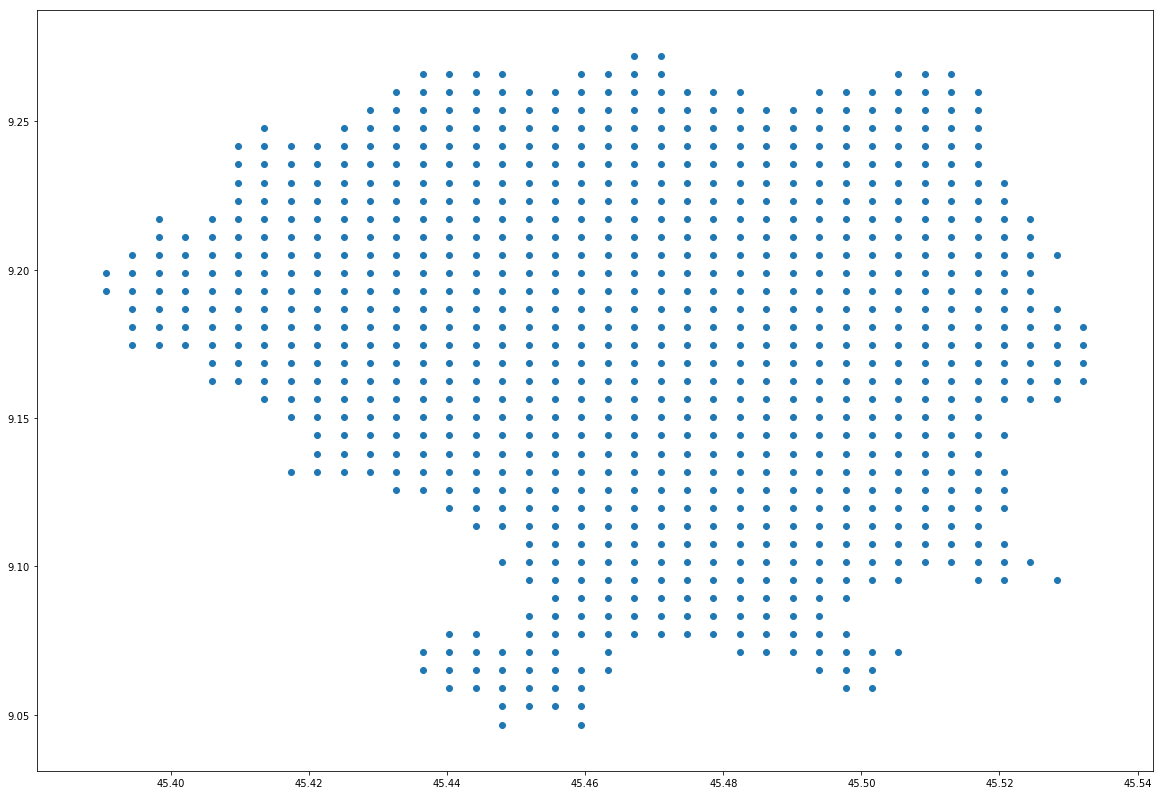

In [62]:
bInBoundary = np.array(ww).reshape(xPlot.shape)
bInBoundary.mean()

plt.scatter(xPlot[bInBoundary], yPlot[bInBoundary])
plt.show()

In [10]:
## Plot tools
class unitPlotter:
    '''
    A class that plots various types of output from a list of ServiceUnits
    '''
    def __init__(self, unitList, gridSize=40):
        assert isinstance(unitList, list), 'List expected'
        assert all([isinstance(t, ServiceUnit) for t in unitList]), 'ServiceUnits expected in list'
        self.units = unitList
        self.gridSize = gridSize
        # precompute coordinate ranges
        self.latRange = (min(self.latitude), max(self.latitude))
        self.longRange = (min(self.longitude), max(self.longitude))
        
        # precompute plotting grid
        (self.xPlot, self.yPlot) = np.meshgrid(np.linspace(*self.longRange, gridSize),
                                               np.linspace(*self.latRange, gridSize),
                                        indexing='ij')
        # construct point objects with same shape
        self.plotPoints = np.empty_like(self.xPlot, dtype=object)
        for (i,j),_ in np.ndenumerate(self.plotPoints):
            self.plotPoints[i,j] = geopy.Point(self.yPlot[i,j], self.xPlot[i,j]) # (lat, long) format
        
        self.serviceValues = {}
    
    @property
    def longitude(self):
        return [unit.site.longitude for unit in self.units]
    @property
    def latitude(self):
        return [unit.site.latitude for unit in self.units]
    @property
    def scale(self):
        scales = [unit.scale for unit in self.units]
        return scales
    
    
    def plot_locations(self):
        '''
        Plots the loaded ServiceUnits according to their locations and rescaling the relative sizes
        '''
        plotScales = self.scale/np.mean(self.scale)
        plt.figure()
        plt.scatter(self.latitude, self.longitude, s=plotScales)
        plt.axis('equal')
        plt.show()
        
    def compute_service_levels(self, servType):
        '''
        Evaluates on a grid the aggregate service level for the loaded ServiceUnits of a selected type.
        '''
        assert isinstance(servType, ServiceType), 'ServiceType expected in input'
        
        # extend internal cache with computed values
        self.serviceValues[servType] = evaluate_services_at(
            self.plotPoints.reshape(-1), self.units, [servType])[servType]
        return None
        
    def plot_service_levels(self, servType):
        '''
        Plots a contour graph of the results for each ageGroup.
        '''
        assert isinstance(servType, ServiceType), 'ServiceType expected in input'
        for ageGroup, valuesSeries in self.serviceValues[servType].items():
            valuesArray = np.vectorize(lambda p: valuesSeries[tuple(p)])(self.plotPoints)
            plt.figure()
            plt.title(ageGroup)
            CS = plt.contourf(self.xPlot, self.yPlot, valuesArray)
            cbar = plt.colorbar(CS)
            cbar.ax.set_ylabel('Service level')
            plt.show()
            
        return None

In [11]:
plotter = unitPlotter(schoolUnits, gridSize=40)
plotter.compute_service_levels(ServiceType.School)

plotterLight = unitPlotter(schoolUnits, gridSize=16)
plotterLight.compute_service_levels(ServiceType.School)

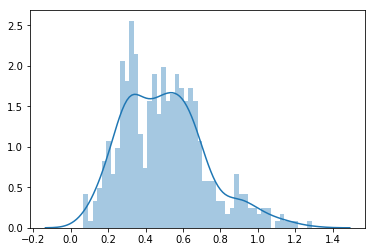

In [12]:
sns.distplot(plotter.scale,50)

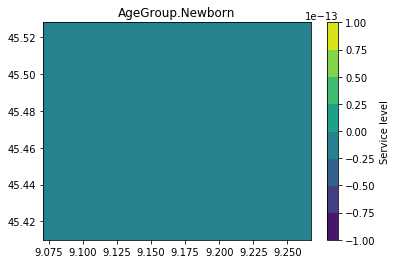

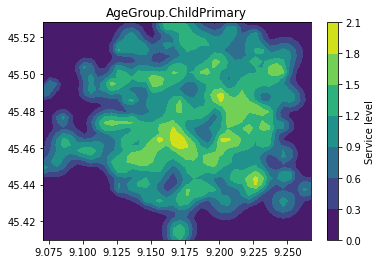

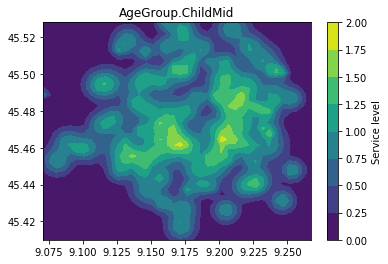

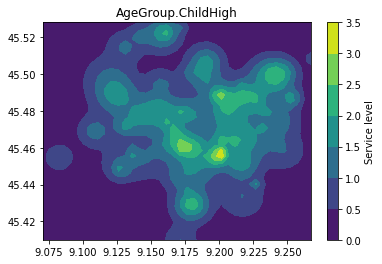

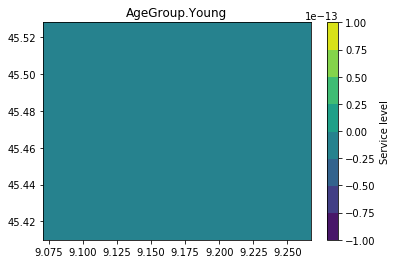

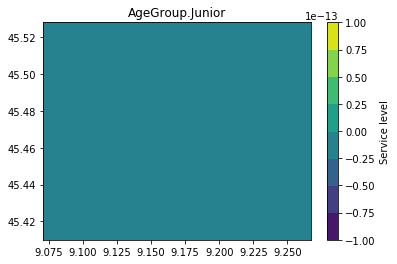

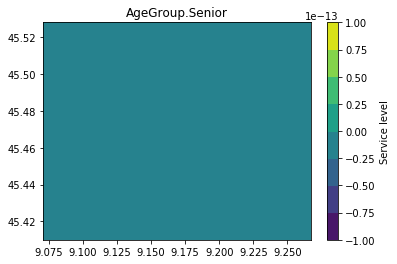

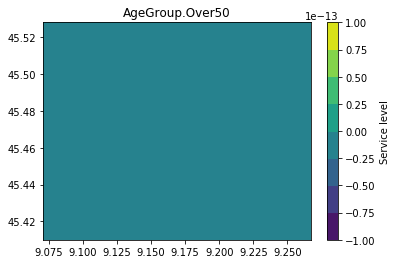

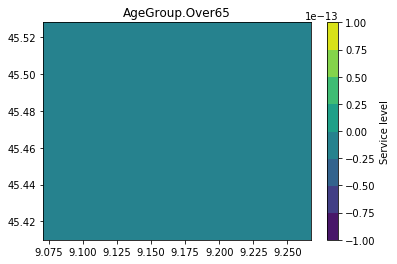

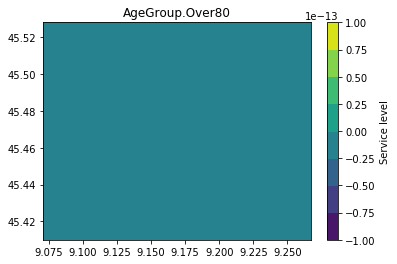

In [13]:
plotter.plot_service_levels(ServiceType.School)

In [14]:
import geopandas as gpd


In [15]:
class zoneIntegrator:

    def __init__(self, unitList, divisionFilesDict):
        assert isinstance(unitList, list), 'List expected'
        assert all([isinstance(t, ServiceUnit) for t in unitList]), 'ServiceUnits expected in list'
        self.units = unitList
        
        # load division geofiles with geopandas
        self.divisions = {}
        for name, fileName in divisionFilesDict.items():
            self.divisions[name] = gpd.read_file(fileName)
        
    def compute_means(self):
        quartiereKey = 'quartieri'
        for iRow in range(self.divisions[quartiereKey].shape[0]):
            thisPolygon = self.divisions[quartiereKey].loc[iRow, 'geometry']
            gridPoints = np.random.uniform(thisPolygon.bounds)
            print(thisPolygon)


In [16]:
from shapely.geometry import Point
def grid_points_within(poly, nGrid=100:
    min_x, min_y, max_x, max_y = poly.bounds
    
    while len(points) < num_points:
        random_point = Point([np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            points.append(random_point)

    return points

SyntaxError: invalid syntax (<ipython-input-16-2121438e68ac>, line 2)

In [ ]:
thisPolygon = zint.divisions['quartieri'].loc[0, 'geometry']
testPoints = random_points_within(thisPolygon,2)

xx =  random_points_within(thisPolygon,20)
for t in xx:
    plt.plot(t)
plt.plot(thisPolygon)
plt.show()
#[geopy.Point(p.y, p.x) for p in xx]
#xx

In [ ]:
zint = zoneIntegrator(schoolUnits, {'quartieri':'data/milanoNIL.geojson'})
#zint.divisions['quartieri'].plot()
zint.compute_means()


In [ ]:
zz = zint.divisions['quartieri']
zz

## Demand modelling

In [ ]:
polySample = zz['geometry'][86]
ww = np.asarray(polySample.exterior.coords)

In [ ]:
### Demand modelling
class Household:
    def __init__(self, position=None, membersInput=None):
        # make defaults
        if not position: position = get_random_pos(1)
        if not membersInput: membersInput = {a: 1 for a in AgeGroup.all()}
        # expand input to all age group keys
        self.members = {a: membersInput.get(a, 0) for a in AgeGroup.all()}
        self.position = position
        self.export = pd.DataFrame(self.members, index=([self.position])) # precompute for speed

def evaluate_demand(householdList, outputServices= [t for t in ServiceType]):
    """ """
    # initialise output
    outDemand = dict()
    # consolidate positions. If two households share the same position, sum components.
    householdData = pd.concat([h.export for h in householdList])
    householdData['position'] = householdData.index 
    consolidated = householdData.groupby('position').sum()
    
    for thisServType in outputServices:
        outDemand[thisServType] = consolidated*thisServType.demandFactors
        
    return outDemand

In [ ]:
hhList =  [Household() for i in range(40)]
evaluate_demand(hhList)

In [ ]:
## Matching demand and supply
def get_satisfaction_indexes(householdList)